### 1. Content Based Recommender System 

We will try to build a system that recommends recipes that are similar to a particular recipe. We will use recipe ingredients and categories to determine similarity and then list the top 10 closest matches.

In [365]:
%load_ext Cython
%time
%cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


UsageError: Line magic function `%cython` not found (But cell magic `%%cython` exists, did you mean that instead?).


In [366]:
#import needed packages
from gensim.models import doc2vec

import re
import pandas as pd
import numpy as np
import copy

# nltk processing
import nltk
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier

In [367]:
# read in fields title, ingredients and categories
data = pd.read_csv("dataRecTitleCatsIngred.csv") 

#data.duplicated()


In [368]:
data.drop_duplicates()

,title,categories,ingred
0,1-Dish Taco Bake,"['Trusted Brands: Recipes and Tips', ""ARGO&#17...","['Taco Meat Filling:', '1 pound ground beef', ..."
1,15-Minute Dinner Nachos Supreme,"['Trusted Brands: Recipes and Tips', ""Campbell...","['1 pound ground beef', '1 (1.12 ounce) packag..."
2,A Firefighter's Meatloaf,"['Main Dish', 'Meatloaf', 'Beef Meatloaf']","['2 slices whole wheat bread', '2 pounds groun..."
3,Aaron's Missouri Burger,"['Main Dish', 'Burgers', 'Hamburgers']","['1 pound lean ground beef', '2 teaspoons onio..."
4,Absolute Best Liver and Onions,['Main Dish'],"['2 pounds sliced beef liver', '1 1/2 cups mil..."
5,Adobo Sirloin,"['World Cuisine', 'Latin American', 'Mexican']","['1 lime, juiced', '1 tablespoon minced garlic..."
6,Albondigas,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","['1 quart water', '4 carrots, sliced', '2 smal..."
7,Albondigas Soup I,"['Soups, Stews and Chili', 'Soup', 'Pork Soup']","['1 pound lean ground beef', '1/4 pound pork s..."
8,Albondigas Soup II,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","['1 pound lean ground beef', '2 cubes beef bou..."
9,Alison's Slow Cooker Vegetable Beef Soup,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","['1 1/2 pounds cubed beef stew meat', '2 cups ..."


We will define a food vocabulary. Non-food words, such as measurements, punctuation, and descriptions about the state of a food item should be removed.

In [369]:
### removed measurements, descriptive words and anything that's not an ingredient
def clean_data_ingred(ds):
    arr = ['tablespoons','tablespoon','teaspoons','teaspoon','cups','cup','ounces','ounce','pounds','pound','pinches','pinch','tastes','taste','dashes','dash','/',' or ',' as ',' and ',
          '-','[',']','(',')','.','slices','sliced','slice', '0','1','2','3','4','5','6','7','8','9','juiced','diced','minced','chopped',' cans',' canned ',' can ', ' inches ', ' inch ',
          'package', 'finely', 'crushed', 'shredded', 'divided', ' melted ', ' jar ','thawed', ' cut ', ' to ', ' thick ', ' across ', ' bones ', 'optional', ' split ', ' torn ',
          ' into ', ' strips ', 'peeled',' pieces', ' lightly ', ' beaten ','ground black', 'scrubbed', 'jars', 'beaten','pitted','halved', 'thinly','as needed','large','medium','small'
          'roughly','fluid','drained','crumbled','rinsed','cubed','seeded','fresh',' plus ', ' more ', 'deboned', 'prepared', 'cubes', 'uncooked', 'cooked', 'grated', ' lean ','into chunks',
          'coarsely','seeded','freshly',' freshly', 'fresh', ' with ', 'liquid','quartered','lengthwise','small',' into ',' bite ', ' sized ', ' ly ', ' ed ', ' s ','cut into', ' up ',
          'trimmed','frozen','chunks','segments','softened',' cut ','pieces','broken',' rings',' torn ',' into ','eighths','quarters','halves','thirds',' thick ', ' ',"'"]

    ### merge terms that have multiple words, for example 'ground beef' becomes 'groundbeef'
    for item in arr:
        ds = ds.str.replace(item,'')
    ds = ds.str.replace(',,',',')
    return ds

In [370]:
### Remove measurements and anything else that is not a food ingredient
data['ingred'] = clean_data_ingred(data['ingred'])

#export to csv file to view cleaning results
#data['title'] = clean_data(data['title'])
#dfIngred.to_csv('ingredClean.csv', sep=' ')

data['ingred'].head(10)

0    TacoMeatFilling:,groundbeef,tacoseasoning,Batt...
1    groundbeef,Pace®TacoSeasoningMix,"Campbells®Co...
2    wholewheatbread,groundbeef,greenonion,onion,sa...
3    groundbeef,onionpowder,honeymustard,garlicpowd...
4    beefliver,milk,butter,Vidaliaonions,allpurpose...
5    lime,garlic,driedoregano,groundcumin,chipotlep...
6    quartwater,carrots,potatoes,onion,salsa,hot,be...
7    groundbeef,porksausage,onion,egg,salt,pepper,g...
8    groundbeef,beefbouilloncube,water,clovesgarlic...
9    beefstewmeat,water,onion,tomatoes,mixedvegetab...
Name: ingred, dtype: object

In [371]:
### separate each term with a space
def create_soup(ds):
    ds = ds.str.replace(',',' ')
    return ds

In [372]:
### Separate each ingredient with a space
data['ingredSpaces'] = create_soup(data['ingred'])
data['ingredSpaces'].head(10)

0    TacoMeatFilling: groundbeef tacoseasoning Batt...
1    groundbeef Pace®TacoSeasoningMix "Campbells®Co...
2    wholewheatbread groundbeef greenonion onion sa...
3    groundbeef onionpowder honeymustard garlicpowd...
4    beefliver milk butter Vidaliaonions allpurpose...
5    lime garlic driedoregano groundcumin chipotlep...
6    quartwater carrots potatoes onion salsa hot be...
7    groundbeef porksausage onion egg salt pepper g...
8    groundbeef beefbouilloncube water clovesgarlic...
9    beefstewmeat water onion tomatoes mixedvegetab...
Name: ingredSpaces, dtype: object

### Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each recipe
This will give us a matrix where each column represents a word in the overview vocabulary 
(all the words that appear in at least one recipe) and each column represents a recipe

The TF-IDF score is the frequency of an ingredient occurring in a recipe, down-weighted 
by the number of recipes in which it occurs.


In [373]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data['ingredSpaces'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape


(8110, 5439)

In [374]:
print("5,459 different words were used to describe 8,110 recipes in the dataset")

5,459 different words were used to describe 8,110 recipes in the dataset


Using this matrix we can compute a similarity score. We will use a cosine similarity to calculate a number that denotes the similarity between two recipes.

cosine(x,y0 = x.y^T / ||x||.||y||

Since we have used the TF-IDF vectorizer, calculating the dot product will give us the cosine similarity score. We will use sklearn's linear_kernel() because it is faster.


In [375]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We're going to define a function that takes in a recipe title as an input and outputs a list of the 10 most similar recipes. 

To do this, we will need a reverse mapping of recipe titles and dataframe indices. This will give us a way to identify the index of a recipe, given its title.

In [383]:
#Construct a reverse map of indices and recipe titles
indices = pd.Series(data.index, index=data['ingredSpaces']).drop_duplicates()

indices.head(5)

ingredSpaces
TacoMeatFilling: groundbeef tacoseasoning Batter: MazolaPure®CookingSpray allpurposeflour masacornflourORcornmeal "envelopesFleischmanns®RapidRiseYeast" sugar salt verywarmmilkdegreesFdegreesF Mazola®CornOil egg Topping: chunkysalsa Mexicanstylecheese cornchips partially    0
groundbeef Pace®TacoSeasoningMix "Campbells®CondensedTomatoSoup" water instantwhiterice Pace®Thick&ChunkySalsa ShreddedCheddarcheese Shreddedlettuce Tortillachips                                                                                                                 1
wholewheatbread groundbeef greenonion onion salsa wholegrainDijonmustard Worcestershiresauce garlic saltpepper barbequesauce                                                                                                                                                       2
groundbeef onionpowder honeymustard garlicpowder redpepper salt brownsugar oliveoil Swisscheese hamburgerbuns                                               

In [377]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data['ingredSpaces'])


In [378]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [379]:
# Reset index of our main DataFrame and construct reverse mapping
data = data.reset_index()
indices = pd.Series(data.index, index=data['ingred'])

In [380]:
# Function that takes in ingredient as input and outputs most similar ingredients
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the recipe title that matches the title
    idx = indices[title]

    print("idx[title] = ",idx)
    
    # Get the pairwise similarity scores of all titles with that title
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
 
    # Get the recipe indices
    recipe_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar recipes
    return data['title'].iloc[recipe_indices]

In [381]:
get_recommendations(20, cosine_sim2)  #Ann's Dirty Rice


idx[title] =  20


1257                 Ann's Dirty Rice
848                        Porcupines
2085                       Porcupines
236                 Cabbage Rolls III
557               Hamburger Rice Soup
1473                Cabbage Rolls III
1794              Hamburger Rice Soup
3489                   Zucchini Saute
728     Melinda's Porcupine Meatballs
1965    Melinda's Porcupine Meatballs
Name: title, dtype: object

In [382]:
get_recommendations(8083) #Shrimp and Quinoa

idx[title] =  8083


3166                      Grilled Asparagus
3170                     Asparagus Parmesan
2536    Cranberry and Cilantro Quinoa Salad
8030                          Shrimp Quinoa
4300                Spicy and Sweet Spinach
3151                    Pan-Fried Asparagus
7880                  Shrimp and Okra Gumbo
5972       Goat Cheese and Asparagus Quinoa
3520             The Best Steamed Asparagus
5988                 Spiced Quinoa Porridge
Name: title, dtype: object

In [26]:
get_recommendations(8100) #tuna salad with cranberries

idx[title] =  8100


7980                            Quick Tuna Salad
7750                      Avocado and Tuna Tapas
2568                                 Egg Salad I
2543                        Mom's Cucumber Salad
7958                              Halibut Weaver
3568    Asparagus with Cranberries and Pine Nuts
4324                   Creamy Buttered Cucumbers
2473                       Holiday Chicken Salad
2722                       Holiday Chicken Salad
8062                         Cheesy Baked Salmon
Name: title, dtype: object

In [27]:
data['title'].head()

0                   1-Dish Taco Bake
1    15-Minute Dinner Nachos Supreme
2           A Firefighter's Meatloaf
3            Aaron's Missouri Burger
4     Absolute Best Liver and Onions
Name: title, dtype: object

In [28]:
get_recommendations(14) #american lasagne

idx[title] =  14


1251          American Lasagna
6180          American Lasagna
669     Lasagna Stuffed Shells
1906    Lasagna Stuffed Shells
410             Easy Lasagna I
1647            Easy Lasagna I
1164         That's-a Meatloaf
2400         That's-a Meatloaf
1042          Spaghetti Pie II
2278          Spaghetti Pie II
Name: title, dtype: object

In [29]:
get_recommendations(8108) #Mainely Fish

idx[title] =  8108


3354             Summer Vegetable Ratatouille
4087                          Sauteed Cabbage
253                      Carne Asada Marinade
1490                     Carne Asada Marinade
3390                         Roasted Broccoli
3337    Olive Oil Roasted Eggplant with Lemon
7892       Pan-Poached Alaskan Salmon Piccata
7493         Grilled Tilapia with Mango Salsa
4924     Spring Fiddleheads and Sweet Peppers
7857                    Pasta With Tuna Sauce
Name: title, dtype: object

### Next, we'll add more features to help improve recommendations. We'll add Categories..

In [384]:
def clean_categories(ds):
#    for item in ds:
    ds = ds.str.replace(' ','')
    ds = ds.str.lower()
    ds = ds.str.replace('[','')
    ds = ds.str.replace(']','')
    ds = ds.str.replace("''",' ')
    ds = ds.str.replace(',',' ')
    ds = ds.str.replace("'","")
    return ds



In [385]:
data['categories_clean'] = clean_categories(data['categories'])
data['categories_clean'].head()

0    trustedbrands:recipesandtips "argo&#174; karo&...
1      trustedbrands:recipesandtips "campbellskitchen"
2                       maindish meatloaf beefmeatloaf
3                          maindish burgers hamburgers
4                                             maindish
Name: categories_clean, dtype: object

We will use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an ingredient if it appears in relatively more recipes.


In [386]:
# Merge ingredients and categories into one column
data['ingred_cat'] = data['ingredSpaces'] + ' ' + data['categories_clean'] 


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data['ingred_cat'])

In [34]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [35]:
# Reset index of the main DataFrame and construct reverse mapping as before
data = data.reset_index()
indices = pd.Series(data.index, index=data['ingred_cat'])

In [36]:
indices.head()

ingred_cat
TacoMeatFilling: groundbeef tacoseasoning Batter: MazolaPure®CookingSpray allpurposeflour masacornflourORcornmeal "envelopesFleischmanns®RapidRiseYeast" sugar salt verywarmmilkdegreesFdegreesF Mazola®CornOil egg Topping: chunkysalsa Mexicanstylecheese cornchips partially trustedbrands:recipesandtips "argo&#174; karo&#174; fleischmanns&#174;"    0
groundbeef Pace®TacoSeasoningMix "Campbells®CondensedTomatoSoup" water instantwhiterice Pace®Thick&ChunkySalsa ShreddedCheddarcheese Shreddedlettuce Tortillachips trustedbrands:recipesandtips "campbellskitchen"                                                                                                                                         1
wholewheatbread groundbeef greenonion  onion salsa wholegrainDijonmustard Worcestershiresauce garlic saltpepper barbequesauce maindish meatloaf beefmeatloaf                                                                                                                                       

In [37]:
get_recommendations(19, cosine_sim2)

idx[title] =  19


1256    Angel's Old Fashioned Beef Stew
827          Pauline Werner's Beef Stew
2064         Pauline Werner's Beef Stew
477                    French Beef Stew
1714                   French Beef Stew
806             Old-Fashioned Beef Stew
2043            Old-Fashioned Beef Stew
600                     Irish Beef Stew
1837                    Irish Beef Stew
979             Slow Cooker Beef Stew I
Name: title, dtype: object

In [38]:
get_recommendations(477, cosine_sim2)

idx[title] =  477


1714                   French Beef Stew
160                   Beer Beef Stew II
568                    Hearty Beef Stew
1397                  Beer Beef Stew II
1805                   Hearty Beef Stew
19      Angel's Old Fashioned Beef Stew
1256    Angel's Old Fashioned Beef Stew
979             Slow Cooker Beef Stew I
2215            Slow Cooker Beef Stew I
6060            Slow Cooker Beef Stew I
Name: title, dtype: object

In [39]:
get_recommendations(8108, cosine_sim2) #Mainely Fish

idx[title] =  8108


8090                                 Spicy Red Snapper
7493                  Grilled Tilapia with Mango Salsa
7791                             Red Snapper Livornese
8026                                 Easiest Spicy Cod
7784                                     Fish Roll-Ups
7857                             Pasta With Tuna Sauce
7745                               Haddock Bubbly Bake
7892                Pan-Poached Alaskan Salmon Piccata
3354                      Summer Vegetable Ratatouille
7781    Pan Fried Halibut Steak with Light Green Sauce
Name: title, dtype: object

In [40]:
get_recommendations(0, cosine_sim2) #1 dish taco bake

idx[title] =  0


1237                                     1-Dish Taco Bake
2766                                    Blackened Chicken
5875                              Mango- Coconut Smoothie
3099    Original Nestle® Toll House Chocolate Chip Coo...
4076                          Creamed Spinach from Oikos®
511                              Grands!® Easy Taco Melts
1748                             Grands!® Easy Taco Melts
5874                          Beet-Red Raspberry Smoothie
596                      Impossibly Easy Cheeseburger Pie
1833                     Impossibly Easy Cheeseburger Pie
Name: title, dtype: object

In [41]:
get_recommendations(8083, cosine_sim2) #Shrimp and Quinoa

idx[title] =  8083


8030                                     Shrimp Quinoa
8040                                      Shrimp Verde
7966              Shrimp with Tomatoes and Feta Cheese
8034                        Lemon Pepper Pasta Seafood
7853                     Lemony Shrimp over Brown Rice
7909               Camarones al Ajillo (Garlic Shrimp)
7833                                Sexy Shrimp Scampi
7681    Fire Roasted Tomato and Feta Pasta with Shrimp
7441                  Garlicky Appetizer Shrimp Scampi
7789                  Garlicky Appetizer Shrimp Scampi
Name: title, dtype: object

## 2 - Recommender System Considering Ratings and Number of Reviews

Since ratings can be different based on the number of reviews, for example should a recipe with only 3 ratings, where the average rating is 5.0, be evaluated as having a truly higher rating than a recipe with 500 ratings, where the average rating is about 4.0?<br>

In order to be fair, we are going to use a weighted ratings.<br>

v: number of reviews for the recipe<br>

m: minimum number of votes required to be listed<br>

R: average rating of the recipe<br>

C: mean vote across all recipes<br>

We will use 90th percentile as the cutoff in terms of number of reviews.<br>


In [42]:
# read in fields title, ingredients and categories
dataR = pd.read_csv("dataRecTitleCatsIngredRatRev.csv") 

dataR.duplicated()
dataR.drop_duplicates()

,title,categories,ingred,rating,review_cnt
0,1-Dish Taco Bake,"['Trusted Brands: Recipes and Tips', ""ARGO&#17...","['Taco Meat Filling:', '1 pound ground beef', ...",4.41,86
1,15-Minute Dinner Nachos Supreme,"['Trusted Brands: Recipes and Tips', ""Campbell...","['1 pound ground beef', '1 (1.12 ounce) packag...",4.00,1
2,A Firefighter's Meatloaf,"['Main Dish', 'Meatloaf', 'Beef Meatloaf']","['2 slices whole wheat bread', '2 pounds groun...",4.37,262
3,Aaron's Missouri Burger,"['Main Dish', 'Burgers', 'Hamburgers']","['1 pound lean ground beef', '2 teaspoons onio...",4.67,150
4,Absolute Best Liver and Onions,['Main Dish'],"['2 pounds sliced beef liver', '1 1/2 cups mil...",4.17,9
5,Adobo Sirloin,"['World Cuisine', 'Latin American', 'Mexican']","['1 lime, juiced', '1 tablespoon minced garlic...",4.00,4
6,Albondigas,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","['1 quart water', '4 carrots, sliced', '2 smal...",4.25,1362
7,Albondigas Soup I,"['Soups, Stews and Chili', 'Soup', 'Pork Soup']","['1 pound lean ground beef', '1/4 pound pork s...",4.28,34
8,Albondigas Soup II,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","['1 pound lean ground beef', '2 cubes beef bou...",4.00,2
9,Alison's Slow Cooker Vegetable Beef Soup,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","['1 1/2 pounds cubed beef stew meat', '2 cups ...",4.71,6


In [43]:
C = dataR['rating'].mean()
print("average rating of all recipes: ",C)

average rating of all recipes:  4.158191122071517


In [44]:
m = dataR['review_cnt'].quantile(0.5)
print("50th percentile number of reviews: ",m)

50th percentile number of reviews:  74.0


In [45]:
# Filter out all qualified recipes into a new DataFrame
q_data = dataR.copy().loc[dataR['review_cnt'] >= m]
q_data.shape

(4068, 5)

In [46]:
q_data.duplicated()
q_data.drop_duplicates()

,title,categories,ingred,rating,review_cnt
0,1-Dish Taco Bake,"['Trusted Brands: Recipes and Tips', ""ARGO&#17...","['Taco Meat Filling:', '1 pound ground beef', ...",4.41,86
2,A Firefighter's Meatloaf,"['Main Dish', 'Meatloaf', 'Beef Meatloaf']","['2 slices whole wheat bread', '2 pounds groun...",4.37,262
3,Aaron's Missouri Burger,"['Main Dish', 'Burgers', 'Hamburgers']","['1 pound lean ground beef', '2 teaspoons onio...",4.67,150
6,Albondigas,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","['1 quart water', '4 carrots, sliced', '2 smal...",4.25,1362
23,Apple Flavored Pot Roast,"['Main Dish', 'Roasts']","['1 (3 pound) boneless beef chuck roast', '1 (...",4.39,137
27,Asian Beef Skewers,['Everyday Cooking'],"['3 tablespoons hoisin sauce', '3 tablespoons ...",4.65,3837
28,Asian Beef with Snow Peas,"['World Cuisine', 'Asian', 'Chinese']","['3 tablespoons soy sauce', '2 tablespoons ric...",4.65,3837
29,Asian Fire Meat,"['World Cuisine', 'Asian', 'Chinese']","['1/2 cup soy sauce', '1 tablespoon sesame oil...",4.64,3837
32,Asian Style Meatloaf,"['World Cuisine', 'Asian']","['1 1/2 pounds ground beef', '1/2 pound ground...",4.47,115
33,Atomic Canuck Chili,"['Soups, Stews and Chili', 'Chili', 'Beef Chili']","['2 pounds lean ground beef', '1/2 large onion...",4.61,325


There are 4068 recipes which qualify to be in this list. Now, we need to calculate our metric for each qualified recipe. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified recipes:

In [47]:
# Function that computes the weighted rating of each recipe
def weighted_rating(x, m=m, C=C):
    v = x['review_cnt']
    R = x['rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)




In [48]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_data['score'] = q_data.apply(weighted_rating, axis=1)

In [49]:
#Sort movies based on score calculated above
q_data = q_data.sort_values('score', ascending=False)

#Print the top 15 movies
q_data[['title', 'review_cnt', 'rating', 'score']].head(25)

,title,review_cnt,rating,score
1947,Meatball Soup,1023,4.91,4.859285
1948,Meatball Spaghetti Sauce,1019,4.91,4.859100
3203,Dad's Pan-Fried Green Beans,9837,4.84,4.834909
3202,Cream Peas,9836,4.84,4.834909
7021,Pork Chops with Apple Curry Sauce,1390,4.86,4.824526
1232,Zippy Beef Casserole,1777,4.85,4.822343
5600,Coconut Raspberry Smoothie,9933,4.82,4.815106
5601,Chia Ginger Smoothie,9933,4.82,4.815106
5602,Paleo Apple Pie Smoothie,9933,4.82,4.815106
2495,Delicious Egg Salad for Sandwiches,544,4.90,4.811175


After evaluating the Ratings and number of reviews, it does not seem that these values are reliable indicators of how popular a recipe would actually be.  For example, it is highly unlikely that "Cream Peas" would be a family's fourth most favorite recipe.  The list above shows Meatball Soup, as the top rated recipe, with a 4.91 average rating. I find it hard to believe that a soup recipe is truly the most popular recipe.  Meatball Spaghetti Sauce, at number 2, possibly may be, but Dad's Pan-Fried Green Beans in third place and Cream Peas in fourth? Not likely. Therefore, we will not be using the average rating and number of reviews in our recommender system.

## Word2Vec, Doc2Vec

In [267]:
from string import punctuation
from os import listdir
from numpy import array
#from array import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from gensim.models import Word2Vec

data.head(10)

,level_0,index,title,categories,ingred,ingredSpaces,categories_clean,ingred_cat
0,0,0,1-Dish Taco Bake,"['Trusted Brands: Recipes and Tips', ""ARGO&#17...","TacoMeatFilling:,groundbeef,tacoseasoning,Batt...",TacoMeatFilling: groundbeef tacoseasoning Batt...,"trustedbrands:recipesandtips ""argo&#174; karo&...",TacoMeatFilling: groundbeef tacoseasoning Batt...
1,1,1,15-Minute Dinner Nachos Supreme,"['Trusted Brands: Recipes and Tips', ""Campbell...","groundbeef,Pace®TacoSeasoningMix,""Campbells®Co...","groundbeef Pace®TacoSeasoningMix ""Campbells®Co...","trustedbrands:recipesandtips ""campbellskitchen""","groundbeef Pace®TacoSeasoningMix ""Campbells®Co..."
2,2,2,A Firefighter's Meatloaf,"['Main Dish', 'Meatloaf', 'Beef Meatloaf']","wholewheatbread,groundbeef,greenonion,,onion,s...",wholewheatbread groundbeef greenonion onion s...,maindish meatloaf beefmeatloaf,wholewheatbread groundbeef greenonion onion s...
3,3,3,Aaron's Missouri Burger,"['Main Dish', 'Burgers', 'Hamburgers']","groundbeef,onionpowder,honeymustard,garlicpowd...",groundbeef onionpowder honeymustard garlicpowd...,maindish burgers hamburgers,groundbeef onionpowder honeymustard garlicpowd...
4,4,4,Absolute Best Liver and Onions,['Main Dish'],"beefliver,milk,,butter,,Vidaliaonions,,allpurp...",beefliver milk butter Vidaliaonions allpurp...,maindish,beefliver milk butter Vidaliaonions allpurp...
5,5,5,Adobo Sirloin,"['World Cuisine', 'Latin American', 'Mexican']","lime,,garlic,driedoregano,groundcumin,chipotle...",lime garlic driedoregano groundcumin chipotle...,worldcuisine latinamerican mexican,lime garlic driedoregano groundcumin chipotle...
6,6,6,Albondigas,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","quartwater,carrots,,potatoes,,onion,,salsa,hot...",quartwater carrots potatoes onion salsa hot...,soups stewsandchili soup beefsoup,quartwater carrots potatoes onion salsa hot...
7,7,7,Albondigas Soup I,"['Soups, Stews and Chili', 'Soup', 'Pork Soup']","groundbeef,porksausage,onion,,egg,,salt,pepper...",groundbeef porksausage onion egg salt pepper...,soups stewsandchili soup porksoup,groundbeef porksausage onion egg salt pepper...
8,8,8,Albondigas Soup II,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","groundbeef,beefbouilloncube,water,clovesgarlic...",groundbeef beefbouilloncube water clovesgarlic...,soups stewsandchili soup beefsoup,groundbeef beefbouilloncube water clovesgarlic...
9,9,9,Alison's Slow Cooker Vegetable Beef Soup,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","beefstewmeat,water,onion,,tomatoes,mixedvegeta...",beefstewmeat water onion tomatoes mixedvegeta...,soups stewsandchili soup beefsoup,beefstewmeat water onion tomatoes mixedvegeta...


Word2Vec learns the context of a word by looking at the words which commonly occur around the target word. Words which have similar contexts share meaning under Word2Vec, and their reduced vector representations will be similar.  In the skip-gram model version of Word2Vec the goal is to take a target word and predict the surrounding context words. We will attempt to apply this technique to recipe ingredients,learning ingredients that commonly occur together. 

We will supply our input target words as one-hot vectors to the neural network.  Then, via a hidden layer, we want to train the neural network to increase the probability of valid context words, while decreasing the probability of invalid context words.

There are two variants of the Word2Vec paradigm – skip-gram and CBOW.  The skip-gram variant takes a target word and tries to predict the surrounding context words, while the CBOW (continuous bag of words) variant takes a set of context words and tries to predict a target word.  In this case, we will be considering the skip-gram variant.

We also need a way of ensuring that, as the network trains, words which are similar end up having similar embedding vectors.  Therefore, we want to ensure that the trained network will always output a 1 when it is supplied words which are in the same context, but 0 when it is supplied words which are never in the same context. Therefore, we need a vector similarity score supplied to the output sigmoid layer – with similar vectors outputting a high score and un-similar vectors outputting a low score.  The most typical similarity measure used between two vectors is the cosine similarity score:

In [273]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, merge
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import urllib
import collections
import os
import zipfile

import numpy as np
import tensorflow as tf


In [274]:
import gensim 
import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras


In [275]:
#siraj:

In [276]:
from __future__ import absolute_import, division, print_function
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns


In [277]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claudiacassidy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claudiacassidy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [278]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

tokenizer

In [81]:
#def sentence_to_wordlist(raw):
#    clean = re.sub("[^a-zA-Z]"," ", raw)
#    words = clean.split()
#    return words

In [387]:
print(data['title'][5])

Adobo Sirloin


In [388]:
print(data['ingred_cat'][5])

lime garlic driedoregano groundcumin chipotlepeppersinadobosauce adobosaucefromchipotlepeppers beefsirloinsteaks saltpepper worldcuisine latinamerican mexican


In [389]:
sentences = []
for raw_sentence in data['ingred_cat']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [390]:
print(sentences[5])


['lime', 'garlic', 'driedoregano', 'groundcumin', 'chipotlepeppersinadobosauce', 'adobosaucefromchipotlepeppers', 'beefsirloinsteaks', 'saltpepper', 'worldcuisine', 'latinamerican', 'mexican']


In [391]:
#vectors help with distance, similarity, ranking

#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300

#minimum word count threshold
min_word_count = 3

num_workers = multiprocessing.cpu_count()

#context window length
context_size = 7

#downsample setting for frequent words
#0 - 1e-5 is good for this
downsampling = 1e-3

#random number generator
#deterministic, good for debugging
seed = 1


In [392]:
token_count = sum([len(sentence) for sentence in sentences])
token_count

101898

#### Train Word2Vec

In [397]:
model = w2v.Word2Vec(sg=1,
                     seed=seed,
                     workers=num_workers,
                     size=num_features,
                     min_count=min_word_count,
                     window=context_size,
                     sample=downsampling)

In [398]:
# loads corpus into memory
model.build_vocab(sentences, update=False)


In [399]:
model.train(sentences,total_examples=model.corpus_count,epochs=10)

(710568, 1018980)

In [401]:
# save the trained model to file model.w2v
if not os.path.exists("trained"):
    os.makedirs("trained")

model.save(os.path.join("trained","model.w2v"))

In [402]:
# to load the model from file
ingred_cat_model = w2v.Word2Vec.load(os.path.join("trained", "model.w2v"))

In [403]:
# TSNE is a tool to visualize high dimensional data. 
tsne = sklearn.manifold.TSNE(n_components=2,random_state=0)

In [404]:
all_word_vectors_matrix = ingred_cat_model.wv.syn0

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [406]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

array([[ 14.431845 ,  12.627437 ],
       [-35.18809  ,   3.34186  ],
       [ 21.246082 ,  11.912458 ],
       ...,
       [-22.975374 , -25.984047 ],
       [ -9.8433075,  -6.5128264],
       [ 46.436504 ,   1.6940229]], dtype=float32)

In [407]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[ingred_cat_model.wv.vocab[word].index])
            for word in ingred_cat_model.wv.vocab
        ]
    ],
    columns=["word","x","y"]
)

In [409]:
# Reset index of the main DataFrame and construct reverse mapping as before
data = data.reset_index()
indices = pd.Series(data.index, index=data['ingred_cat'])

In [419]:
data['title'].head(5)

0                   1-Dish Taco Bake
1    15-Minute Dinner Nachos Supreme
2           A Firefighter's Meatloaf
3            Aaron's Missouri Burger
4     Absolute Best Liver and Onions
Name: title, dtype: object

In [420]:
points.head(10)

,word,x,y
0,groundbeef,-16.281675,42.887379
1,tacoseasoning,-37.046967,-38.381184
2,Batter,19.447186,0.373316
3,allpurposeflour,18.732748,20.412664
4,sugar,-5.803090,-34.934891
5,salt,14.431845,12.627437
6,Mazola,32.077087,-3.656636
7,CornOil,32.179993,-3.721092
8,egg,22.283718,34.989414
9,Topping,37.741394,30.127501


In [425]:
import seaborn as sns
sns.set_context("poster")

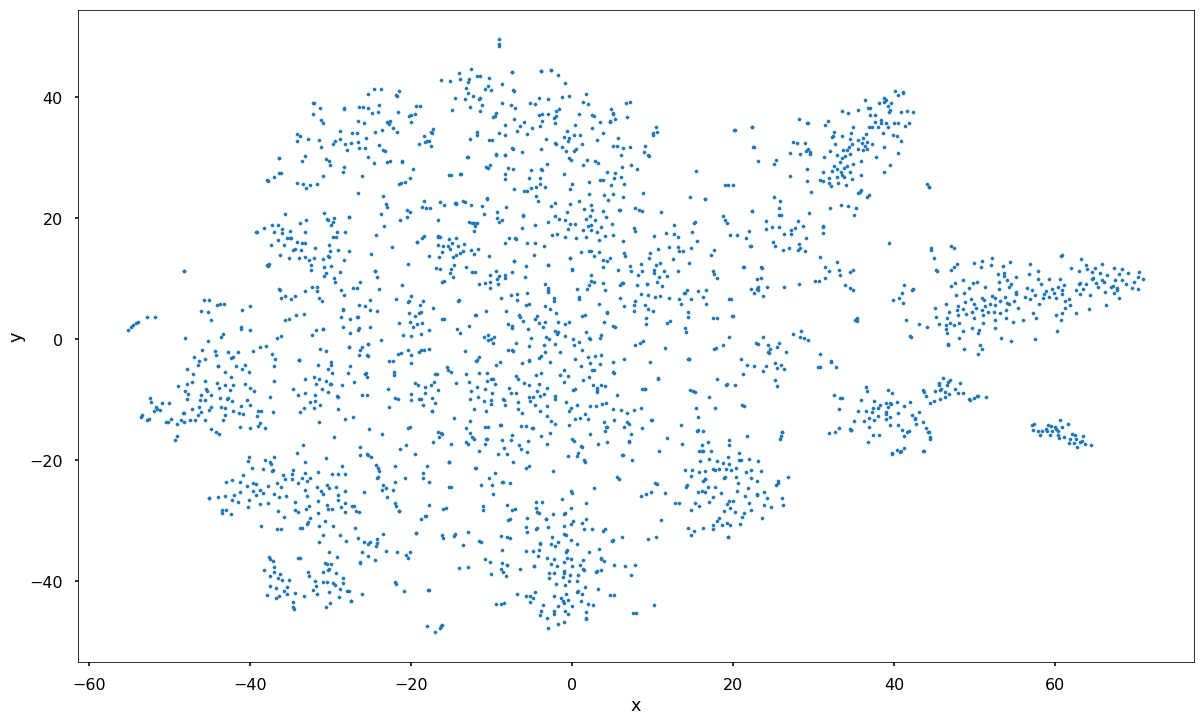

In [426]:
#plot the word vectors
points.plot.scatter("x","y", s=10, figsize=(20,12))

In [427]:
#zoom in

def plot_region(x_bounds,y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10,8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
    

In [434]:
plot_region(x_bounds=(13.1,13.8), y_bounds=(-0.1,-1.1))

ValueError: scatter requires x column to be numeric

In [435]:
#plot_region(x_bounds=(15.1,15.8), y_bounds=(-0.5,-0.1))

ingred_cat_model.wv.most_similar("groundbeef")

[('extraleangroundbeef', 0.7356250882148743),
 ('condensedtomatosoup', 0.6989212036132812),
 ('porksausage', 0.6954190731048584),
 ('groundbeefchuck', 0.6940377354621887),
 ('instantrice', 0.6824647188186646),
 ('bulkporksausage', 0.6729822158813477),
 ('TEL', 0.6727503538131714),
 ('tomatojuice', 0.6723383665084839),
 ('tomatoesgreenchilepepperssuchRO', 0.6694866418838501),
 ('stuffedzucchini', 0.6672079563140869)]

In [436]:
ingred_cat_model.wv.most_similar("tomatoes")

[('Italiansausagelinks', 0.8368695974349976),
 ('Anaheimpeppers', 0.8261488676071167),
 ('groundround', 0.8234143257141113),
 ('driedcilantro', 0.8193094730377197),
 ('cantomatoes', 0.8190802335739136),
 ('bulkItaliansausage', 0.813493013381958),
 ('yellowonions', 0.809718132019043),
 ('bulkmildItaliansausage', 0.8080230355262756),
 ('Italianstylestewedtomatoes', 0.807325005531311),
 ('quartschickenbroth', 0.8067505955696106)]

In [437]:
ingred_cat_model.wv.most_similar("rice")

[('friedrice', 0.8810513019561768),
 ('condensedtomatosoup', 0.8477404117584229),
 ('blackeyedpeas', 0.8467891216278076),
 ('intothick', 0.8464306592941284),
 ('stuffedmaindishes', 0.8408159017562866),
 ('stuffedbellpeppers', 0.8394567966461182),
 ('stuffedcabbage', 0.8350907564163208),
 ('instantrice', 0.8222181797027588),
 ('naturaltomatosauce', 0.8219606876373291),
 ('processedcheesefoodsuchVelveeta', 0.813773512840271)]

In [438]:
ingred_cat_model.wv.most_similar("chicken")

[('chickenbreasts', 0.9502776861190796),
 ('bonelesschickenbreast', 0.8759595155715942),
 ('skinless', 0.8608869314193726),
 ('fried', 0.835036039352417),
 ('pan', 0.8347164988517761),
 ('skillet', 0.8336899876594543),
 ('breaded', 0.8335711359977722),
 ('chickenthighs', 0.8305376768112183),
 ('broiled', 0.8292872905731201),
 ('healthy', 0.824722409248352)]

In [439]:
ingred_cat_model.wv.most_similar("eggs")

[('egg', 0.8394571542739868),
 ('eggwhite', 0.7619562149047852),
 ('cornflakescereal', 0.7279994487762451),
 ('cornbread', 0.70540851354599),
 ('bakingpowder', 0.7033950090408325),
 ('unbakedpiecrust', 0.6925650835037231),
 ('groundItaliansausage', 0.6924121379852295),
 ('quickcookingoats', 0.689365029335022),
 ('slightly', 0.6874478459358215),
 ('pintheavycream', 0.6872473359107971)]

In [440]:
ingred_cat_model.wv.most_similar("almondmilk")

[('groundflaxseed', 0.9812976121902466),
 ('scoopvanillaproteinpowder', 0.9812918305397034),
 ('flaxseedmeal', 0.9797073602676392),
 ('almondbutter', 0.9781345129013062),
 ('mixedberries', 0.9754925966262817),
 ('matchagreenteapowder', 0.9752683043479919),
 ('lowfatvanillayogurt', 0.974659264087677),
 ('macapowder', 0.9735732674598694),
 ('cashewbutter', 0.9735172390937805),
 ('vanillaGreekyogurt', 0.9722342491149902)]

In [441]:
ingred_cat_model.wv.most_similar("avocado")

[('grapefruit', 0.8541820049285889),
 ('washeddried', 0.8468179106712341),
 ('cucumber', 0.8342385292053223),
 ('plainGreekyogurt', 0.8256480693817139),
 ('mintleaves', 0.82147216796875),
 ('leaveskale', 0.8161839246749878),
 ('avocadosalad', 0.8133246898651123),
 ('Englishcucumber', 0.8128377199172974),
 ('babyspinachleaves', 0.8093380928039551),
 ('avocados', 0.8063600659370422)]

In [442]:
ingred_cat_model.wv.most_similar("apple")

[('GrannySmithapple', 0.9037986397743225),
 ('cored', 0.8700090050697327),
 ('pears', 0.8617218732833862),
 ('Galaapple', 0.8326077461242676),
 ('rawbeet', 0.8276614546775818),
 ('apples', 0.8256626129150391),
 ('headredcabbage', 0.8218163251876831),
 ('redapple', 0.81715327501297),
 ('thickcutbacon', 0.8169894218444824),
 ('cashews', 0.8164117932319641)]

In [443]:
ingred_cat_model.wv.most_similar("cabbage")

[('headcabbage', 0.8835433721542358),
 ('carawayseeds', 0.8041573762893677),
 ('headredcabbage', 0.7862439751625061),
 ('chickenbouillon', 0.7531886100769043),
 ('watercover', 0.7507092952728271),
 ('coredcutwedges', 0.7374725937843323),
 ('headgreencabbage', 0.7234316468238831),
 ('saltpork', 0.7229088544845581),
 ('condensedchickenbroth', 0.7196251749992371),
 ('cornedbeefbrisketspicepacket', 0.7169418334960938)]

In [444]:
ingred_cat_model.wv.most_similar("corn")

[('cornpudding', 0.8593905568122864),
 ('earscorn', 0.8432409763336182),
 ('huskedcleaned', 0.8266010284423828),
 ('cornkernels', 0.8251307010650635),
 ('earscornonthecob', 0.8225612640380859),
 ('huskssilkremoved', 0.8167896866798401),
 ('sweetcorn', 0.814145565032959),
 ('husked', 0.8043323755264282),
 ('kernelsfromcob', 0.7984507083892822),
 ('poblanopeppers', 0.7825639247894287)]

In [445]:
ingred_cat_model.wv.most_similar("mushrooms")

[('Burgundywine', 0.7810350656509399),
 ('pasta', 0.7783232927322388),
 ('browngravymix', 0.7647144198417664),
 ('beefconsomme', 0.7646705508232117),
 ('driedchives', 0.7638620138168335),
 ('condensedgoldenmushroomsoup', 0.7601180076599121),
 ('Italianplumtomatoes', 0.7468626499176025),
 ('farfallebowtiepasta', 0.7383450269699097),
 ('loafFrenchbread', 0.7374840974807739),
 ('allpurposeflourforcoating', 0.7372764348983765)]

In [446]:
ingred_cat_model.wv.most_similar("pasta")

[('chickenparmesan', 0.8837072253227234),
 ('lasagna', 0.8817387223243713),
 ('unbakedpiecrusts', 0.8805190920829773),
 ('driedchives', 0.8678560853004456),
 ('dryItalianstylesaladdressingmix', 0.8668407201766968),
 ('Frenchbaguette', 0.8666869401931763),
 ('Genoasalami', 0.8587844371795654),
 ('bonelesschickenbreastthin', 0.8559886813163757),
 ('Marsalawine', 0.8530734777450562),
 ('farfallebowtiepasta', 0.849245548248291)]

In [447]:
ingred_cat_model.wv.most_similar("beans")

[('cucumbersalad', 0.9530304670333862),
 ('seafoodseasoning', 0.936469554901123),
 ('suchOldBay', 0.9340481758117676),
 ('shucked', 0.9228181838989258),
 ('halibutfillets', 0.9154809713363647),
 ('macaronisalad', 0.9108555912971497),
 ('tortellinipastasalad', 0.9108366966247559),
 ('avocadosalad', 0.9098523855209351),
 ('bottleCatalinasaladdressing', 0.9089670777320862),
 ('Frenchdressing', 0.9004061222076416)]

In [448]:
ingred_cat_model.wv.most_similar("quinoa")

[('leaves', 0.8833202123641968),
 ('babyspinach', 0.8606897592544556),
 ('stemsdiscarded', 0.8386727571487427),
 ('rawalmonds', 0.8343982696533203),
 ('ribcelery', 0.8331032991409302),
 ('coconutoil', 0.831213116645813),
 ('Salad', 0.8306911587715149),
 ('grapeseedoil', 0.829585075378418),
 ('ripemango', 0.8280558586120605),
 ('mintleaves', 0.825596272945404)]

In [449]:
ingred_cat_model.wv.most_similar("spinach")

[('kale', 0.692763090133667),
 ('almondflour', 0.6847525238990784),
 ('moreneeded', 0.6833562254905701),
 ('unzucchini', 0.6818087100982666),
 ('squeezeddry', 0.6806218028068542),
 ('asdesired', 0.6669938564300537),
 ('groundalmonds', 0.6534355878829956),
 ('Swisschard', 0.6531277894973755),
 ('leavesbasil', 0.6225785613059998),
 ('more', 0.6200886964797974)]

In [450]:
ingred_cat_model.wv.most_similar("tofu")

[('palmsugar', 0.9742021560668945),
 ('nectarines', 0.9623150825500488),
 ('redseedlessgrapes', 0.9603049159049988),
 ('sprigsmint', 0.9591659903526306),
 ('mangojuice', 0.9575362205505371),
 ('grapeseedoil', 0.9563784599304199),
 ('agavesyrup', 0.9561328887939453),
 ('segmented', 0.9553252458572388),
 ('unsweetenedflakedcoconut', 0.9550542831420898),
 ('creamofcoconut', 0.9548499584197998)]

In [451]:
ingred_cat_model.wv.most_similar("cookies")

[('semisweetchocolatechips', 0.9709047675132751),
 ('desserts', 0.9695682525634766),
 ('fruitdesserts', 0.9370452165603638),
 ('bakingsoda', 0.9337686896324158),
 ('brownies', 0.9332927465438843),
 ('whitechocolatechips', 0.9209458827972412),
 ('nutdesserts', 0.9200817346572876),
 ('chocolatebrownies', 0.9187315702438354),
 ('butterscotchchips', 0.9183063507080078),
 ('creamoftartar', 0.9181516766548157)]

In [452]:
# using cosine similarity (see wikipedia)

def nearest_similarity_cosmul(start1, end1, end2):
    similarities = ingred_cat_model.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    
    print("{start1} is related to {end1}, as {start2} is related to {end2}")
    return start2
    

In [453]:
nearest_similarity_cosmul("groundbeef","chicken","rice")

{start1} is related to {end1}, as {start2} is related to {end2}


'chilibeans'

In [454]:
nearest_similarity_cosmul("groundbeef","rice","pasta")

{start1} is related to {end1}, as {start2} is related to {end2}


'pepperoni'

In [459]:
nearest_similarity_cosmul("sugar","butter","oliveoil")

{start1} is related to {end1}, as {start2} is related to {end2}


'piecegingerroot'

In [456]:
nearest_similarity_cosmul("salt","pepper","carrots")

{start1} is related to {end1}, as {start2} is related to {end2}


'boilingwater'

In [472]:
# Lookup recipes that contain ingredients
def find_recipes_with_ingredient(ingred,ingred2):
    match = data[data['ingred_cat'].str.contains(ingred)] 
    match2 = match[match['ingred_cat'].str.contains(ingred2)]
    return match2

find_recipes_with_ingredient('spinach','groundbeef')


,level_0,index,title,categories,ingred,ingredSpaces,categories_clean,ingred_cat
114,114,114,Beef Florentine,"['Pasta and Noodles', 'Noodles']","eggnoodles,groundbeef,clovesgarlic,driedoregan...",eggnoodles groundbeef clovesgarlic driedoregan...,pastaandnoodles noodles,eggnoodles groundbeef clovesgarlic driedoregan...
199,199,199,"Blue Cheese, Spinach Meat Loaf Muffins","['Main Dish', 'Meatloaf', 'Beef Meatloaf']","groundbeef,bluecheese,onion,Italianbreadcrumbs...",groundbeef bluecheese onion Italianbreadcrumbs...,maindish meatloaf beefmeatloaf,groundbeef bluecheese onion Italianbreadcrumbs...
222,222,222,Buddy's and Bubba's Homemade Dog Food,['Everyday Cooking'],"chickenleg,brownrice,groundbeef,rolledoats,spi...",chickenleg brownrice groundbeef rolledoats spi...,everydaycooking,chickenleg brownrice groundbeef rolledoats spi...
246,246,246,California Italian Wedding Soup,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","extraleangroundbeef,egg,Italianseasonedbreadcr...",extraleangroundbeef egg Italianseasonedbreadcr...,soups stewsandchili soup beefsoup,extraleangroundbeef egg Italianseasonedbreadcr...
598,598,598,Inside Out Ravioli I,"['Pasta and Noodles', 'Pasta by Shape', 'Ravio...","pasta,spinach,breadcrumbs,eggs,oliveoil,mozzar...",pasta spinach breadcrumbs eggs oliveoil mozzar...,pastaandnoodles pastabyshape ravioli,pasta spinach breadcrumbs eggs oliveoil mozzar...
599,599,599,Inside Out Ravioli II,"['World Cuisine', 'European', 'Italian']","seashellpasta,spinach,groundbeef,pastasauce,Ch...",seashellpasta spinach groundbeef pastasauce Ch...,worldcuisine european italian,seashellpasta spinach groundbeef pastasauce Ch...
686,686,686,Lori's Spicy Chipotle Lasagna,"['World Cuisine', 'European', 'Italian']","groundbeef,bulkhotItaliansausage,onion,pintmus...",groundbeef bulkhotItaliansausage onion pintmus...,worldcuisine european italian,groundbeef bulkhotItaliansausage onion pintmus...
687,687,687,Lots O'Veggies Sausage Spaghetti Sauce,"['Side Dish', 'Sauces and Condiments', 'Sauces...","sweetItaliansausage,casingsremoved,groundbeef,...",sweetItaliansausage casingsremoved groundbeef ...,sidedish saucesandcondiments sauces pastasauces,sweetItaliansausage casingsremoved groundbeef ...
691,691,691,Mama's Italian Wedding Soup,"['Soups, Stews and Chili', 'Soup', 'Beef Soup']","extraleangroundbeef,eggs,driedbreadcrumbs,Parm...",extraleangroundbeef eggs driedbreadcrumbs Parm...,soups stewsandchili soup beefsoup,extraleangroundbeef eggs driedbreadcrumbs Parm...
693,693,693,Manicotti Alla Romana,"['World Cuisine', 'European', 'Italian']","oliveoil,onion,clovesgarlic,groundbeef,salt,sp...",oliveoil onion clovesgarlic groundbeef salt sp...,worldcuisine european italian,oliveoil onion clovesgarlic groundbeef salt sp...
